In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class HOGFeatureValue:        
    def quantize(self, value):
        res = np.floor(value / 20)
        if res >= 9: res = 8
        return res
    
    # reference solution は差分計算でオーバーフローをおこしていそう
    def calc_gx_gy(self, img):
        input_img = img.copy().astype(np.int32)
        H, W = input_img.shape
        gx = np.zeros_like(input_img).astype(np.int32)
        gy = np.zeros_like(input_img).astype(np.int32)
        for y in range(H):
            for x in range(W):
                gx[y, x] = input_img[y, min(x+1, W-1)] - input_img[y, max(x-1, 0)]
                gy[y, x] = input_img[min(y+1, H-1), x] - input_img[max(y-1, 0), x]
        return gx, gy
    
    def calc_mag_ang(self, gx, gy):
        H, W = gx.shape
        mag = np.zeros_like(gx, dtype=np.float32)
        ang = np.zeros_like(gy, dtype=np.float32)
        for y in range(H):
            for x in range(W):
                mag[y, x] = np.sqrt(gx[y, x]**2 + gy[y, x]**2)
                ang[y, x] = np.arctan2(gy[y, x], gx[y, x])
                if ang[y, x] < 0: ang[y, x] += np.pi
                ang[y, x] = self.quantize(ang[y, x] / np.pi * 180.0)
        ang = ang.astype(np.uint8)
        return mag, ang
                
    def get_colorized_ang(self, ang):
        color = [
            [255, 0, 0],
            [0, 255, 0],
            [0, 0, 255],
            [255, 255, 0],
            [255, 0, 255],
            [0, 255, 255],
            [127, 127, 0],
            [127, 0, 127],
            [0, 127, 127],
        ]
        H, W = ang.shape
        colorized_ang = np.zeros((H, W, 3), dtype=np.uint8)
        for i in range(9):
            colorized_ang[ang == i] = color[i]
        return colorized_ang
    
    # reference solution で x, y に掛ける数が 4 なのはおそらく間違い
    def gradient_histogram(self, mag, ang, N):
        H, W = mag.shape
        cell_H, cell_W = H // N, W // N
        histogram = np.zeros((cell_H, cell_W, 9), dtype=np.float32)
        
        for y in range(cell_H):
            for x in range(cell_W):
                for j in range(N):
                    for i in range(N):
                        histogram[y, x, ang[y*N+j, x*N+i]] += mag[y*N+j, x*N+i]
        return histogram
    
    def normalization(self, histogram, C=3, epsilon=1):
        cell_H, cell_W, _ = histogram.shape
        result_histogram = histogram.copy().astype(np.float32)
        for y in range(cell_H):
            for x in range(cell_W):
                result_histogram[y, x] /= np.sqrt(
                    np.sum(
                        histogram[max(y-1, 0):min(y+2, cell_H),
                                  max(x-1, 0):min(x+2, cell_W)]**2
                    ) + epsilon
                )
        return result_histogram
    
    def draw_feature_value(self, img_gray, histogram, N=8):
        H, W = img_gray.shape
        cell_H, cell_W, _ = histogram.shape
        
        output_img = img_gray.copy().astype(np.uint8)
        for y in range(cell_H):
            for x in range(cell_W):
                cx = x*N + N//2
                cy = y*N + N//2
                x1, y1, x2, y2 = cx + N//2 - 1, cy, cx - N//2 + 1, cy
                h = histogram[y, x] / np.sum(histogram[y, x])
                h /= h.max()
                
                for c in range(9):
                    theta = (20 * c + 10) / 180.0 * np.pi
                    rx = int(np.sin(theta)*(x1-cx) + np.cos(theta)*(y1-cy) + cx)
                    ry = int(np.cos(theta)*(x1-cx) - np.cos(theta)*(y1-cy) + cy)
                    lx = int(np.sin(theta)*(x2-cx) + np.cos(theta)*(y2-cy) + cx)
                    ly = int(np.cos(theta)*(x2-cx) - np.cos(theta)*(y2-cy) + cy)
                    color = int(255.0 * h[c])
                    cv2.line(output_img, (lx, ly), (rx, ry), (color, color, color))
        return output_img

In [8]:
class Solver:
    def __init__(self):
        self.hog = HOGFeatureValue()
    
    def problem_66(self, input_img):
        input_img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY).astype(np.int8)
        gx, gy = self.hog.calc_gx_gy(input_img_gray)
        mag, ang = self.hog.calc_mag_ang(gx, gy)
        plt.subplot(1, 2, 1)
        plt.imshow(mag, cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(self.hog.get_colorized_ang(ang), cv2.COLOR_BGR2RGB))
        plt.show()
        
    def problem_67(self, input_img):
        input_img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY).astype(np.int8)
        gx, gy = self.hog.calc_gx_gy(input_img_gray)
        mag, ang = self.hog.calc_mag_ang(gx, gy)
        histogram = self.hog.gradient_histogram(mag, ang, 8)
        for i in range(9):
            plt.subplot(3, 3, i+1)
            plt.imshow(histogram[..., i])
        plt.show()
        
    def problem_68(self, input_img):
        input_img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY).astype(np.int8)
        gx, gy = self.hog.calc_gx_gy(input_img_gray)
        mag, ang = self.hog.calc_mag_ang(gx, gy)
        histogram = self.hog.gradient_histogram(mag, ang, 8)
        histogram = self.hog.normalization(histogram, C=3, epsilon=1)
        for i in range(9):
            plt.subplot(3, 3, i+1)
            plt.imshow(histogram[..., i])
        plt.show()
        
    def problem_69(self, input_img):
        input_img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY).astype(np.int8)
        gx, gy = self.hog.calc_gx_gy(input_img_gray)
        mag, ang = self.hog.calc_mag_ang(gx, gy)
        histogram = self.hog.gradient_histogram(mag, ang, 8)
        histogram = self.hog.normalization(histogram, C=3, epsilon=1)
        output_img = self.hog.draw_feature_value(input_img_gray, histogram, N=8)
        plt.imshow(output_img, cmap="gray")
        plt.show()

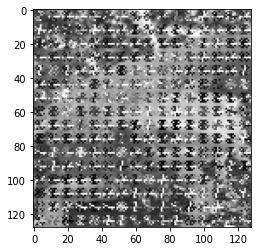

In [9]:
img = cv2.imread("../imori.jpg")
solver = Solver()
solver.problem_69(img)